In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, merge, Convolution3D,Conv3D, MaxPooling3D, UpSampling2D,BatchNormalization,Activation,Dense,Dropout,Flatten
from keras.optimizers import Adam,SGD
from keras import backend as K
K.set_image_dim_ordering('th') 
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential, Model
from sklearn.model_selection import KFold

Using TensorFlow backend.


## Add labels

In [20]:
dataDirectory = '../unlabelled_segment/'
lungPatients = os.listdir(dataDirectory)
labels = pd.read_csv('/home/usma/Downloads/stage1_solution.csv', index_col=0)
size = 50
NoSlices = 40

In [21]:
def dataProcessing(patient, labels_df, size, noslices=40, visualize=False):
    
    label = labels_df.at[patient[:-4], 'cancer']
    path = dataDirectory + patient
    slices = np.load(path)
#     print(slices.shape)
#     slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(each_slice, (size, size)) for each_slice in slices]
#     print(len(slices))

    if label == 1:
        label = np.array([0, 1])
    elif label == 0:
        label = np.array([1, 0])
    return np.array(slices),label



In [ ]:
count=0
imageData = []
for num, patient in enumerate(lungPatients):
    if num % 10 == 0:
        print('Saved -', num)
    try:
        img_data, label = dataProcessing(patient, labels, size=size, noslices=NoSlices)
        imageData.append([img_data, label,patient])
    except KeyError as e:
        print('Data is unlabeled')
        count=count+1
print(count)

## Load files

In [2]:
file1 = np.load("/media/usma/New Volume/usma_10_05_2018/abhishek/kaggle_housfield-50-50-40-1759.npy")
# file2 =  np.load("/media/usma/New Volume/usma_10_05_2018/abhishek/kaggle_NSC_normal.npy")
file3 = np.load("/media/usma/New Volume/usma_10_05_2018/abhishek/unlabelled_data_with_labels.npy")

In [ ]:
# file1 = np.load("/home/usma/Desktop/Research_Project/practical/Myproject/DataFiles/imageDataNew-50-50-20.npy")

In [4]:
print(file1.shape)

(1759, 3)


In [3]:
print(file1.shape)
# print(file2.shape)
print(file3.shape)

(1759, 3)
(198, 3)


## Resample and normalize data

In [4]:
img_rows=50
img_cols=50
depth=40
num_classes=2

In [5]:
def resample(f):
    resample_array=np.zeros((depth,img_rows,img_cols))
    for i in range(len(f)):
        resample_array[i,:,:]=f[i]
    return resample_array

In [6]:
newdata1=np.zeros((len(file1),depth,img_rows,img_cols))
newlabel1=np.zeros((len(file1),2))
for i in range(len(file1)):
    newdata1[i,:,:,:]=resample(file1[i][0])
    newlabel1[i,:]=(file1[i][1])

In [5]:
newdata2=np.zeros((len(file2),depth,img_rows,img_cols))
newlabel2=np.zeros((len(file2),2))
for i in range(len(file2)):
    newdata2[i,:,:,:]=resample(file2[i][0])
    newlabel2[i,:]=(file2[i][1])

In [7]:
newdata3=np.zeros((len(file3),depth,img_rows,img_cols))
newlabel3=np.zeros((len(file3),2))
for i in range(len(file3)):
    newdata3[i,:,:,:]=resample(file3[i][0])
    newlabel3[i,:]=(file3[i][1])

In [8]:
print("Kaggle__data: ",newdata1.shape)
print("Kaggle__label: ",newlabel1.shape)

# print("Kaggle_NSC__data: ",newdata2.shape)
# print("Kaggle_NSC__label: ",newlabel2.shape)

print("Unlabelled_data: ",newdata3.shape)
print("unlabelled__label: ",newlabel3.shape)

Kaggle__data:  (1759, 40, 50, 50)
Kaggle__label:  (1759, 2)
Unlabelled_data:  (198, 40, 50, 50)
unlabelled__label:  (198, 2)


In [11]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata1 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data1=image[:,np.newaxis,:,:];
print(data1.shape)

(1759, 1, 40, 50, 50)


In [12]:
print(newdata1.min())
print(newdata1.max())

-2048.0
4620.39603443


In [13]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata2 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data2=image[:,np.newaxis,:,:];
print(data2.shape)

(2177, 1, 40, 50, 50)


In [14]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata3 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data3=image[:,np.newaxis,:,:];
print(data3.shape)

(198, 1, 40, 50, 50)


In [9]:
data1_N=newdata1[:,np.newaxis,:,:]; ############### WITHOUT NORMALIZATION
# data2_N=newdata2[:,np.newaxis,:,:];
data3_N=newdata3[:,np.newaxis,:,:];######### Test data
print(data1_N.shape)

(1759, 1, 40, 50, 50)


In [10]:
X_train = data1_N
Y_train=newlabel1
X_test = data3_N
Y_test = newlabel3

In [14]:
import gc
del newdata3
# del newlabel3
del file3
del newdata2
del file2
del newdata1
del file1
gc.collect()

214

In [9]:
print(data2_N.shape)

(2177, 1, 40, 50, 50)


In [5]:
# X_T=data3
# Y_T=newlabel3    ####### with normalisation


X_H = data3_N       ########## without normalization
Y_H = newlabel3

print(X_H.shape)

print(Y_H.shape)

NameError: name 'data3_N' is not defined

In [11]:
def plot():
    plt.figure(figsize=(13,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(history.history['acc'], marker='.')
    plt.plot(history.history['val_acc'], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['acc', 'val_acc'], loc='lower right')

# Model 1

In [12]:
model = Sequential()

model.add(Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same', input_shape=(1,depth, img_rows,img_cols)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Convolution3D(128, 3, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

optim = Adam(lr=.001)
model.compile(optimizer=optim, loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 40, 50, 50)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 20, 25, 25)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 20, 25, 25)    128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 20, 25, 25)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 20, 25, 25)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 64, 10, 13, 13)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 10, 13, 13)    256       
__________

In [13]:
history=model.fit(X_train, Y_train,epochs=50,validation_data=(X_test, Y_test),batch_size=32)

Train on 1759 samples, validate on 198 samples
Epoch 1/50
1759/1759 [==============================] - 27s 15ms/step - loss: 0.8392 - acc: 0.5253 - val_loss: 0.9097 - val_acc: 0.6742
Epoch 2/50
1759/1759 [==============================] - 19s 11ms/step - loss: 0.7893 - acc: 0.5341 - val_loss: 1.5172 - val_acc: 0.5960
Epoch 3/50
1759/1759 [==============================] - 19s 11ms/step - loss: 0.7428 - acc: 0.5770 - val_loss: 1.1094 - val_acc: 0.4722
Epoch 4/50
1759/1759 [==============================] - 19s 11ms/step - loss: 0.7227 - acc: 0.5895 - val_loss: 1.7935 - val_acc: 0.4949
Epoch 5/50
1759/1759 [==============================] - 19s 11ms/step - loss: 0.7050 - acc: 0.5949 - val_loss: 1.8801 - val_acc: 0.5631
Epoch 6/50
1759/1759 [==============================] - 19s 11ms/step - loss: 0.6798 - acc: 0.6146 - val_loss: 1.3295 - val_acc: 0.3813
Epoch 7/50
1759/1759 [==============================] - 19s 11ms/step - loss: 0.6924 - acc: 0.6168 - val_loss: 2.1272 - val_acc: 0.5455
E

## KAGGLE DIRECT

Train on 1047 samples, validate on 350 samples
Epoch 1/15
1047/1047 [==============================] - 8s 8ms/step - loss: 0.9323 - acc: 0.5043 - val_loss: 0.8394 - val_acc: 0.4314
Epoch 2/15
1047/1047 [==============================] - 6s 6ms/step - loss: 0.8176 - acc: 0.5444 - val_loss: 0.6872 - val_acc: 0.6086
Epoch 3/15
1047/1047 [==============================] - 6s 6ms/step - loss: 0.7560 - acc: 0.5788 - val_loss: 0.7090 - val_acc: 0.5243
Epoch 4/15
1047/1047 [==============================] - 7s 6ms/step - loss: 0.7031 - acc: 0.6189 - val_loss: 0.6545 - val_acc: 0.6257
Epoch 5/15
1047/1047 [==============================] - 6s 6ms/step - loss: 0.6848 - acc: 0.6461 - val_loss: 0.6118 - val_acc: 0.7114
Epoch 6/15
1047/1047 [==============================] - 6s 6ms/step - loss: 0.6623 - acc: 0.6504 - val_loss: 0.5870 - val_acc: 0.7200
Epoch 7/15
1047/1047 [==============================] - 7s 6ms/step - loss: 0.6738 - acc: 0.6648 - val_loss: 0.6731 - val_acc: 0.5629
Epoch 8/15
1047

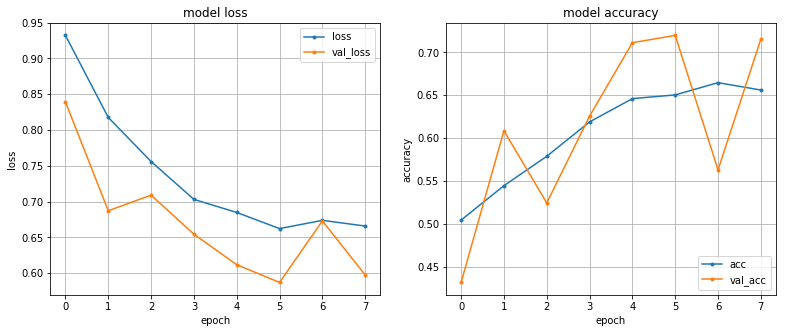

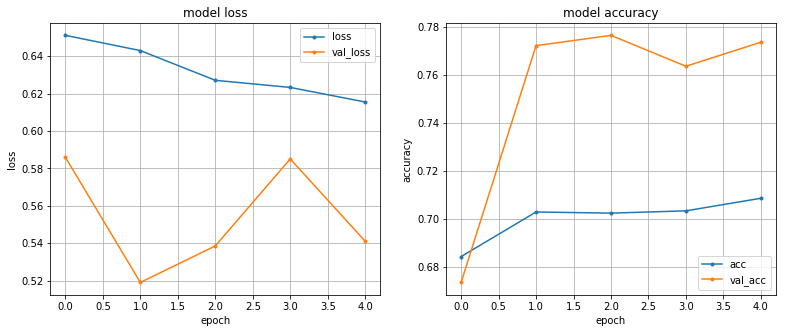

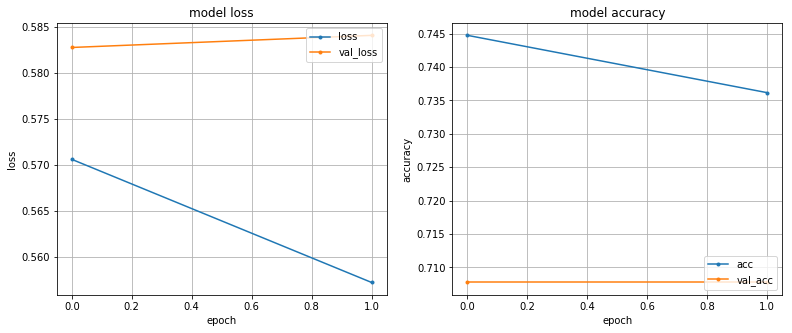

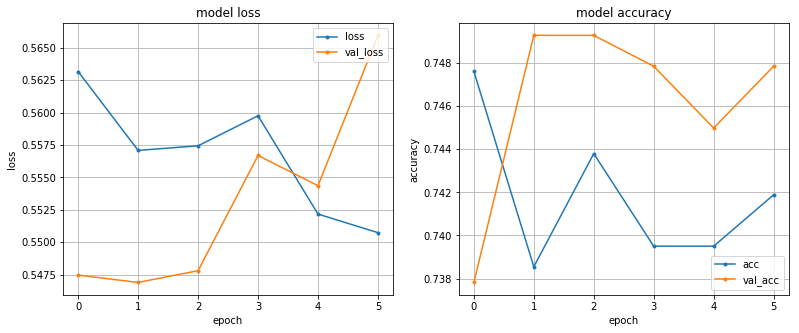

In [11]:
X = data1_N
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

## K FOLD FOR KAGGLE WITH NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.7154 - acc: 0.5804 - val_loss: 0.9470 - val_acc: 0.3977
Epoch 2/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.6832 - acc: 0.5898 - val_loss: 0.8414 - val_acc: 0.4920
Epoch 3/20
1319/1319 [==============================] - 15s 12ms/step - loss: 0.6826 - acc: 0.6031 - val_loss: 1.4230 - val_acc: 0.4159
Epoch 4/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.6544 - acc: 0.6247 - val_loss: 1.4913 - val_acc: 0.4159
Epoch 5/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.6732 - acc: 0.6114 - val_loss: 1.5868 - val_acc: 0.4011
Epoch 6/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.6489 - acc: 0.6232 - val_loss: 1.3237 - val_acc: 0.4239
Epoch 7/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.6330 - acc: 0.6569 - val_loss: 0.9211 - val_acc: 0.4534
E

Epoch 20/20
1319/1319 [==============================] - 16s 12ms/step - loss: 0.1359 - acc: 0.9424 - val_loss: 0.4786 - val_acc: 0.7966
Train on 1320 samples, validate on 439 samples
Epoch 1/20
1320/1320 [==============================] - 16s 12ms/step - loss: 0.3614 - acc: 0.8583 - val_loss: 0.0781 - val_acc: 0.9818
Epoch 2/20
1320/1320 [==============================] - 15s 12ms/step - loss: 0.2713 - acc: 0.8852 - val_loss: 0.1533 - val_acc: 0.9396
Epoch 3/20
1320/1320 [==============================] - 15s 12ms/step - loss: 0.2455 - acc: 0.9091 - val_loss: 0.2118 - val_acc: 0.9043
Epoch 4/20
1320/1320 [==============================] - 16s 12ms/step - loss: 0.2209 - acc: 0.9087 - val_loss: 0.0581 - val_acc: 0.9977
Epoch 5/20
1320/1320 [==============================] - 15s 12ms/step - loss: 0.2040 - acc: 0.9174 - val_loss: 0.0782 - val_acc: 0.9818
Epoch 6/20
1320/1320 [==============================] - 16s 12ms/step - loss: 0.1943 - acc: 0.9242 - val_loss: 0.1372 - val_acc: 0.9453


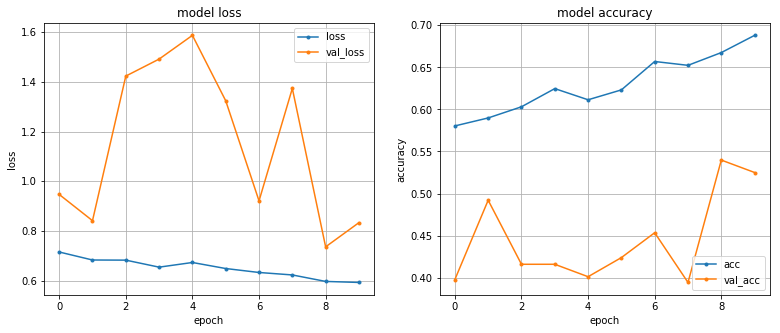

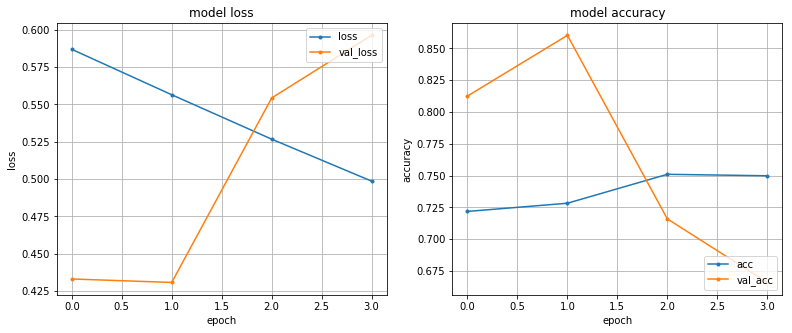

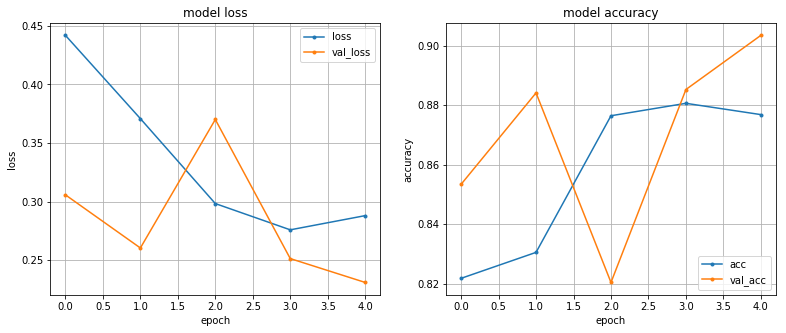

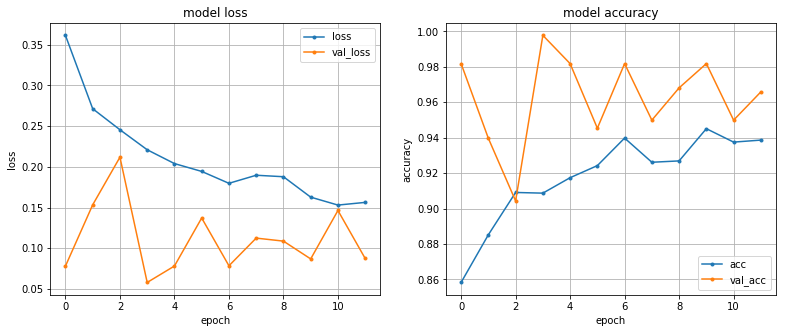

In [22]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=20,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [ ]:
del data1
del newlabel1
del data2
del newlabel2
del data3
del newlabel3
gc.collect()

In [23]:
loss,acc=model.evaluate(X_T,Y_T)

198/198 [==============================] - 1s 4ms/step


In [24]:
print(loss)
print(acc)

1.01329424887
0.651515152117


In [25]:
del model

## KFOLD FOR KAGGLE AND NSCLC  WITH NORMALIZATION

Train on 1632 samples, validate on 545 samples
Epoch 1/15
1632/1632 [==============================] - 22s 14ms/step - loss: 0.6753 - acc: 0.6458 - val_loss: 1.0902 - val_acc: 0.3844
Epoch 2/15
1632/1632 [==============================] - 19s 12ms/step - loss: 0.5834 - acc: 0.6657 - val_loss: 0.7467 - val_acc: 0.5046
Epoch 3/15
1632/1632 [==============================] - 20s 12ms/step - loss: 0.5511 - acc: 0.6756 - val_loss: 1.1594 - val_acc: 0.3853
Epoch 4/15
1632/1632 [==============================] - 20s 12ms/step - loss: 0.5278 - acc: 0.7016 - val_loss: 0.9092 - val_acc: 0.4183
Epoch 5/15
1632/1632 [==============================] - 20s 12ms/step - loss: 0.5276 - acc: 0.6936 - val_loss: 1.6191 - val_acc: 0.3853
Epoch 6/15
1632/1632 [==============================] - 20s 12ms/step - loss: 0.5191 - acc: 0.7077 - val_loss: 0.9624 - val_acc: 0.3899
Epoch 7/15
1632/1632 [==============================] - 20s 12ms/step - loss: 0.5033 - acc: 0.7074 - val_loss: 1.1164 - val_acc: 0.3881
E

Epoch 15/15
1633/1633 [==============================] - 22s 14ms/step - loss: 0.1889 - acc: 0.9271 - val_loss: 0.7745 - val_acc: 0.8906
Validation Loss:  [0.74669571600922746, 0.56626346181420717, 0.40221780976828408, 0.21795534042586737]  Validation accuracy:  [0.50458715596330272, 0.70404411764705888, 0.82628676470588236, 0.9310661764705882]
Average Validation Loss:  0.483283082004
Average Validation Accuracy:  0.741496053697


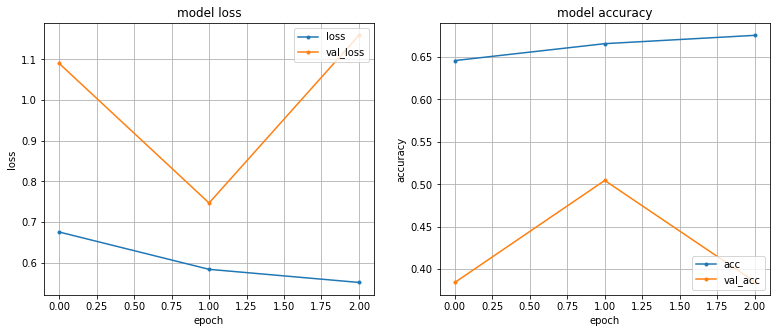

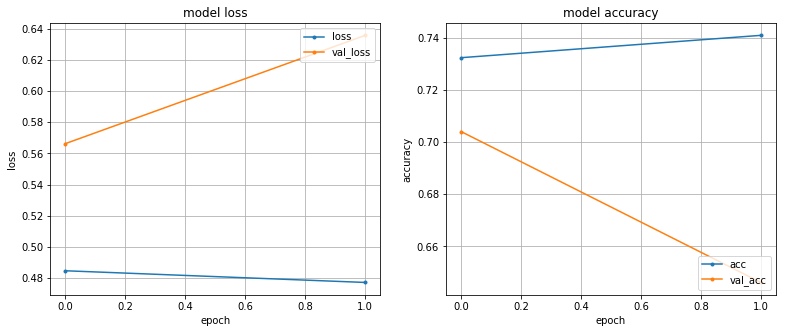

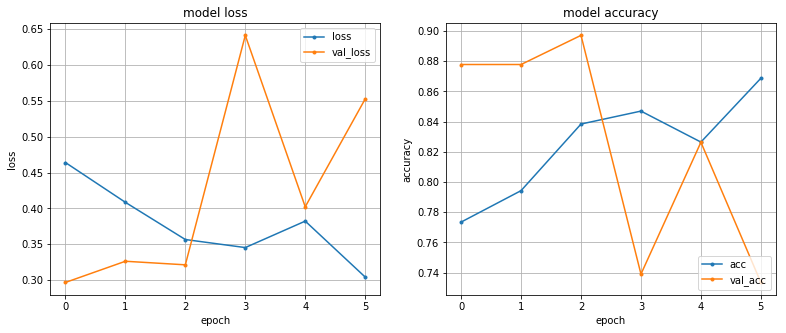

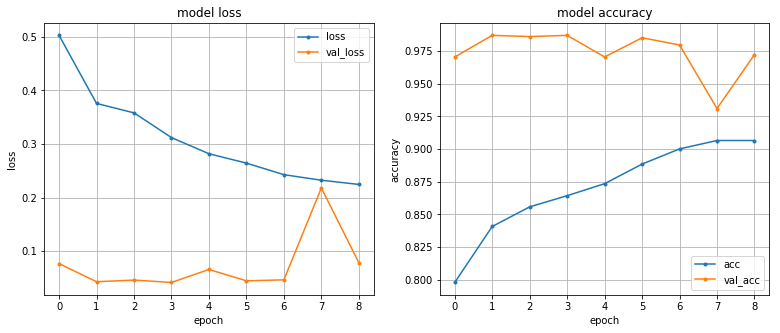

In [69]:
X = data2
Y = newlabel2
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [70]:
loss,acc=model.evaluate(X_T,Y_T);
print(loss)
print(acc)

198/198 [==============================] - 5s 26ms/step
5.22079210089
0.383838384139


## KFOLD FOR KAGGLE WITHOUT NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/15
1319/1319 [==============================] - 26s 20ms/step - loss: 0.8523 - acc: 0.5136 - val_loss: 1.0698 - val_acc: 0.4875
Epoch 2/15
1319/1319 [==============================] - 18s 14ms/step - loss: 0.7823 - acc: 0.5500 - val_loss: 1.0050 - val_acc: 0.4841
Epoch 3/15
1319/1319 [==============================] - 18s 14ms/step - loss: 0.7415 - acc: 0.5788 - val_loss: 0.8781 - val_acc: 0.5102
Epoch 4/15
1319/1319 [==============================] - 18s 14ms/step - loss: 0.7241 - acc: 0.6073 - val_loss: 0.7338 - val_acc: 0.4977
Epoch 5/15
1319/1319 [==============================] - 18s 14ms/step - loss: 0.7089 - acc: 0.5891 - val_loss: 0.7786 - val_acc: 0.4932
Epoch 6/15
1319/1319 [==============================] - 18s 13ms/step - loss: 0.6806 - acc: 0.6096 - val_loss: 1.1143 - val_acc: 0.3966
Epoch 7/15
1319/1319 [==============================] - 18s 13ms/step - loss: 0.6677 - acc: 0.6429 - val_loss: 0.7861 - val_acc: 0.4250
E

Epoch 15/15
1320/1320 [==============================] - 15s 12ms/step - loss: 0.1622 - acc: 0.9405 - val_loss: 0.2109 - val_acc: 0.9123
Validation Loss:  [0.73379466858777131, 0.57022242437709458, 0.31374758373607287, 0.18796869460705473]  Validation accuracy:  [0.49772727164355191, 0.68863636309450327, 0.85454545346173372, 0.93052391650193378]
Average Validation Loss:  0.451433342827
Average Validation Accuracy:  0.742858251175


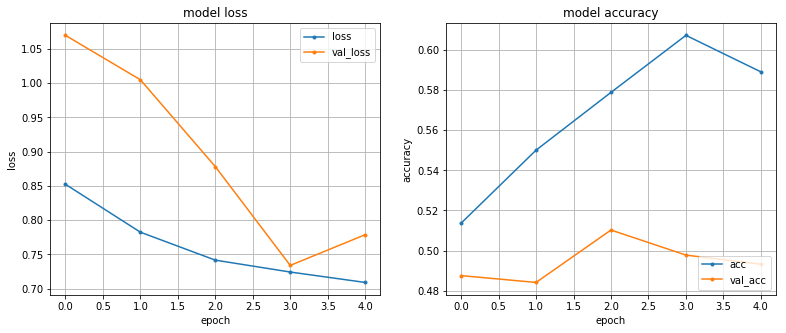

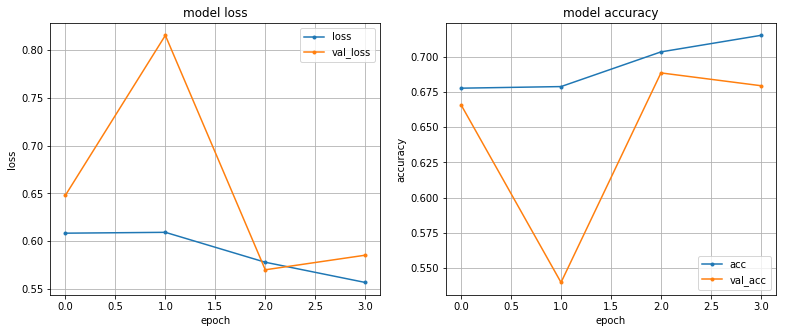

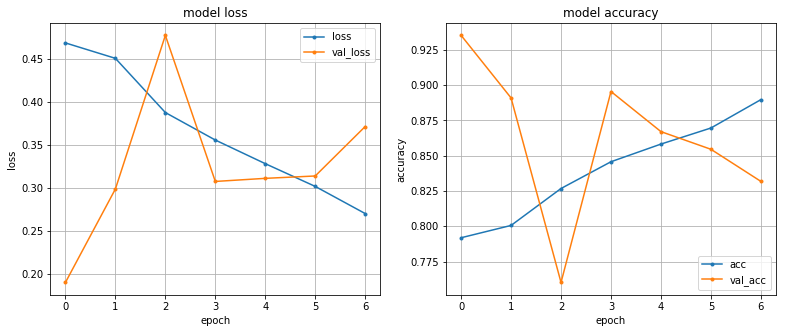

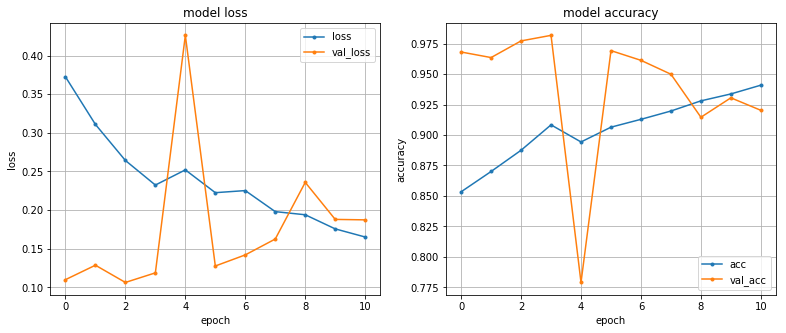

In [19]:
X = data1_N
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [24]:
loss,acc=model.evaluate(X_H,Y_H);
print(loss)
print(acc)

198/198 [==============================] - 1s 3ms/step
0.661425052267
0.590909090909


## KFOLD FOR KAGGLE AND NSCLC WITHOUT NORMALIZATION

Train on 1632 samples, validate on 545 samples
Epoch 1/15
1632/1632 [==============================] - 21s 13ms/step - loss: 0.7194 - acc: 0.6394 - val_loss: 0.9748 - val_acc: 0.4615
Epoch 2/15
1632/1632 [==============================] - 20s 12ms/step - loss: 0.6249 - acc: 0.6777 - val_loss: 0.8538 - val_acc: 0.4817
Epoch 3/15
1632/1632 [==============================] - 19s 12ms/step - loss: 0.5903 - acc: 0.6805 - val_loss: 1.5952 - val_acc: 0.4083
Epoch 4/15
1632/1632 [==============================] - 19s 12ms/step - loss: 0.5695 - acc: 0.6994 - val_loss: 0.7587 - val_acc: 0.4963
Epoch 5/15
1632/1632 [==============================] - 20s 12ms/step - loss: 0.5497 - acc: 0.7016 - val_loss: 0.7608 - val_acc: 0.5541
Epoch 6/15
1632/1632 [==============================] - 19s 12ms/step - loss: 0.5366 - acc: 0.6924 - val_loss: 0.7074 - val_acc: 0.5651
Epoch 7/15
1632/1632 [==============================] - 19s 12ms/step - loss: 0.5213 - acc: 0.7031 - val_loss: 0.9634 - val_acc: 0.6174
E

Epoch 15/15
1633/1633 [==============================] - 19s 12ms/step - loss: 0.1676 - acc: 0.9382 - val_loss: 0.1135 - val_acc: 0.9605
Validation Loss:  [0.70741481431033637, 0.62445169336655559, 0.31924808113013997, 0.38916416027966666]  Validation accuracy:  [0.56513761467889911, 0.61672794117647056, 0.87040441176470584, 0.8345588235294118]
Average Validation Loss:  0.510069687272
Average Validation Accuracy:  0.721707197787


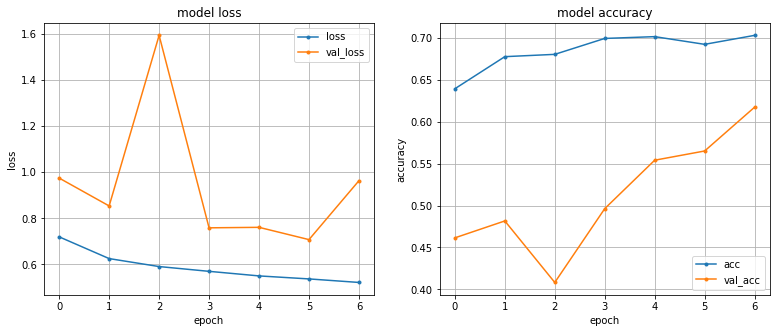

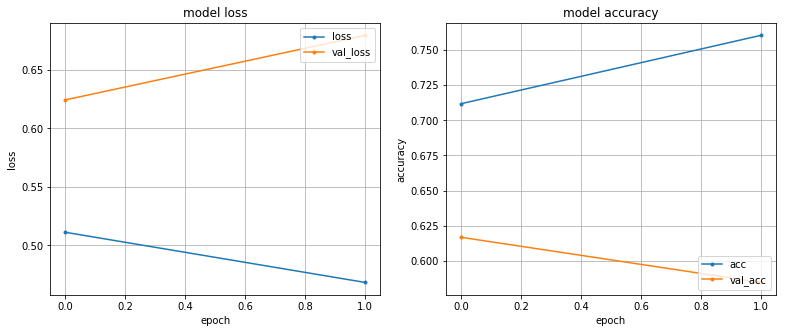

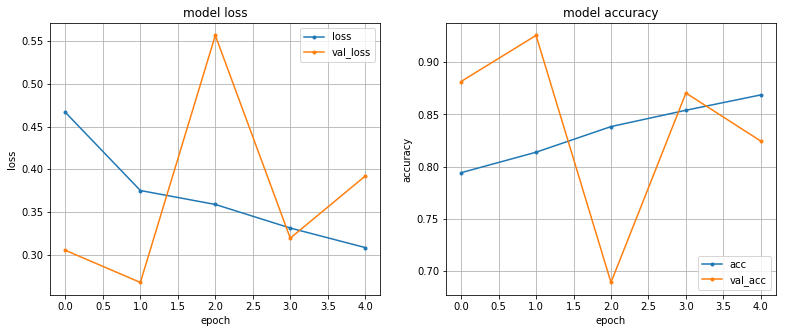

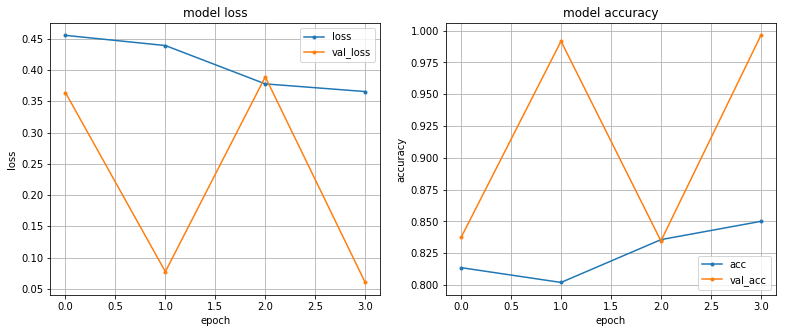

In [27]:
X = data2_N
Y = newlabel2
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [28]:
loss,acc=model.evaluate(X_H,Y_H);print(loss,acc)

198/198 [==============================] - 1s 4ms/step
0.975388207219 0.654040403438


# MODEL 2

In [14]:
model = Sequential()
model.add(Convolution3D(32, 3, 3, 3, activation='relu', padding='same', input_shape=(1,depth, img_rows,img_cols)))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same'))
# model.add(BatchNormalization(axis=1))
# model.add(Dropout(0.5))

# model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))#layer1
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Conv3D(64, kernel_size=(3, 3, 3),  padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same') )#layer2
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer3
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 

model.add(Conv3D(256, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer4
model.add(BatchNormalization(axis=1))

model.add(Dropout(0.5))    

model.add(Conv3D(512, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer5
model.add(BatchNormalization(axis=1))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=.001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 32, 20, 50, 50)    896       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 32, 7, 17, 17)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 7, 17, 17)     128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 7, 17, 17)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 64, 7, 17, 17)     55360     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 7, 17, 17)     0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 64, 3, 6, 6)       0         
__________

##  K FOLD for KAGGLE  WITH NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/15
1319/1319 [==============================] - 12s 9ms/step - loss: 1.2028 - acc: 0.5163 - val_loss: 1.0498 - val_acc: 0.4591
Epoch 2/15
1319/1319 [==============================] - 10s 8ms/step - loss: 1.1562 - acc: 0.5337 - val_loss: 1.3432 - val_acc: 0.6068
Epoch 3/15
1319/1319 [==============================] - 9s 7ms/step - loss: 1.0238 - acc: 0.5277 - val_loss: 1.6499 - val_acc: 0.3818
Epoch 4/15
1319/1319 [==============================] - 9s 7ms/step - loss: 0.9141 - acc: 0.5155 - val_loss: 0.9279 - val_acc: 0.5886
Epoch 5/15
1319/1319 [==============================] - 10s 7ms/step - loss: 0.9073 - acc: 0.5375 - val_loss: 0.7123 - val_acc: 0.5432
Epoch 6/15
1319/1319 [==============================] - 10s 8ms/step - loss: 0.8692 - acc: 0.5299 - val_loss: 0.6677 - val_acc: 0.6159
Epoch 7/15
1319/1319 [==============================] - 10s 7ms/step - loss: 0.8404 - acc: 0.5254 - val_loss: 0.6728 - val_acc: 0.6045
Epoch 8/15

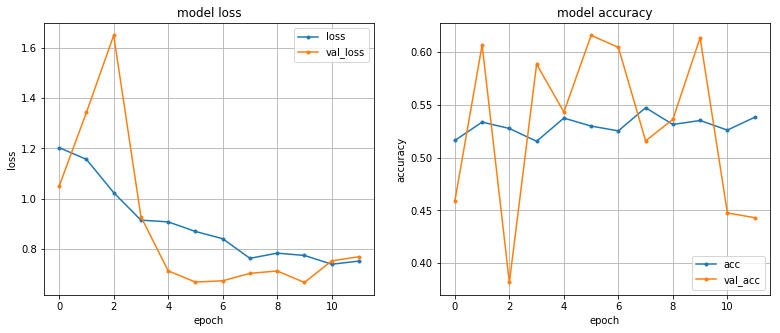

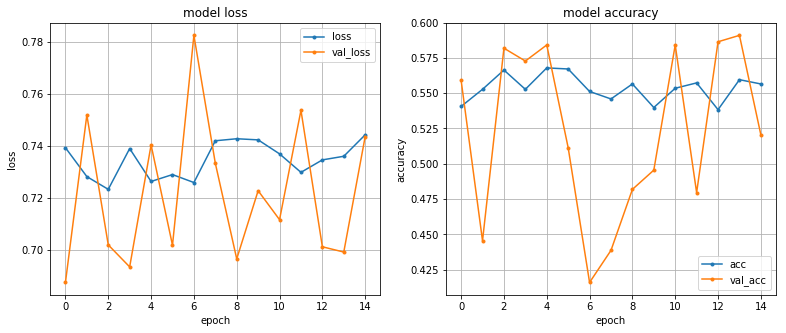

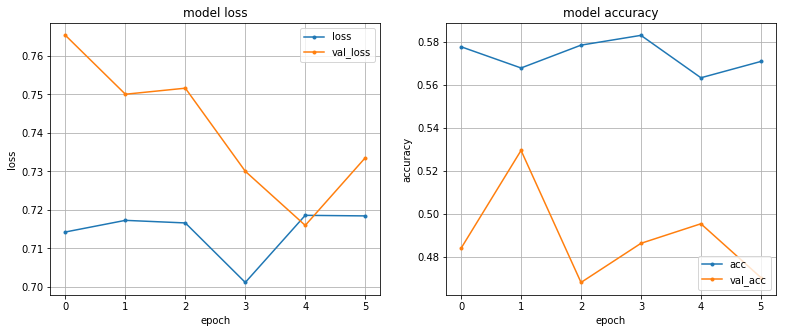

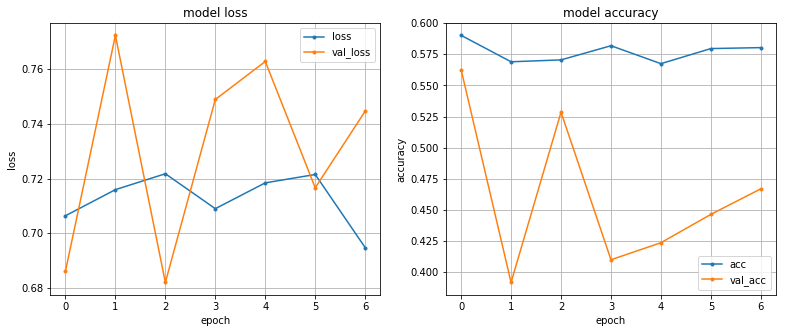

In [55]:
X = data1
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=20,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [65]:
loss,acc=model.evaluate(X_T,Y_T)

198/198 [==============================] - 1s 3ms/step


In [66]:
print(loss,acc)

0.746902311691 0.378787878938


## K FOLD for KAGGLE and NSCLCWITH NORMALIZATION

Train on 1632 samples, validate on 545 samples
Epoch 1/15
1632/1632 [==============================] - 14s 8ms/step - loss: 1.1564 - acc: 0.5251 - val_loss: 0.3313 - val_acc: 0.8624
Epoch 2/15
1632/1632 [==============================] - 13s 8ms/step - loss: 1.0704 - acc: 0.5135 - val_loss: 0.5314 - val_acc: 0.7761
Epoch 3/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.9357 - acc: 0.5129 - val_loss: 0.8142 - val_acc: 0.5303
Epoch 4/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.8991 - acc: 0.5319 - val_loss: 1.5563 - val_acc: 0.1376
Epoch 5/15
1632/1632 [==============================] - 14s 8ms/step - loss: 0.8228 - acc: 0.5263 - val_loss: 0.8867 - val_acc: 0.4239
Epoch 6/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.7883 - acc: 0.5312 - val_loss: 0.6950 - val_acc: 0.5009
Epoch 7/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.7800 - acc: 0.5594 - val_loss: 1.1272 - val_acc: 0.1376
Epoch 8/

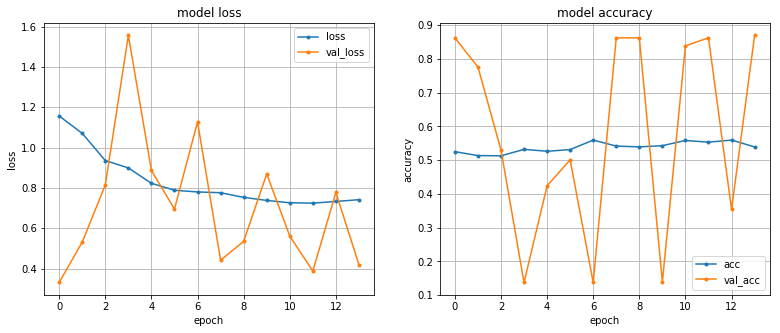

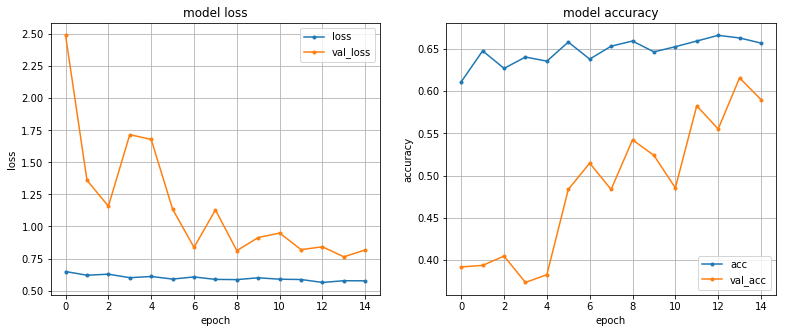

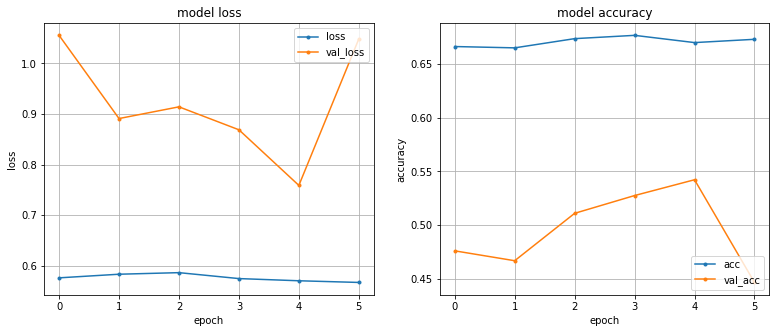

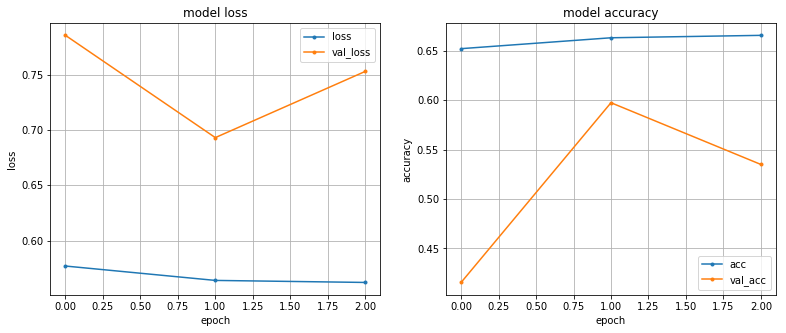

In [72]:
X = X
Y = Y
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [73]:
loss,acc=model.evaluate(X_T,Y_T)

198/198 [==============================] - 1s 3ms/step


In [74]:
print(loss)
print(acc)

0.930244421718
0.287878788029


## KFOLD FOR KAGGLE   WITHOUT NORMALIZATION

Train on 1319 samples, validate on 440 samples
Epoch 1/15
1319/1319 [==============================] - 11s 8ms/step - loss: 1.1950 - acc: 0.5239 - val_loss: 0.7288 - val_acc: 0.5818
Epoch 2/15
1319/1319 [==============================] - 10s 7ms/step - loss: 1.2889 - acc: 0.5224 - val_loss: 1.2432 - val_acc: 0.5955
Epoch 3/15
1319/1319 [==============================] - 10s 7ms/step - loss: 1.1298 - acc: 0.5042 - val_loss: 0.7454 - val_acc: 0.5318
Epoch 4/15
1319/1319 [==============================] - 10s 8ms/step - loss: 1.0696 - acc: 0.5087 - val_loss: 1.1446 - val_acc: 0.6159
Epoch 5/15
1319/1319 [==============================] - 10s 7ms/step - loss: 0.9760 - acc: 0.5201 - val_loss: 1.2302 - val_acc: 0.6068
Epoch 6/15
1319/1319 [==============================] - 10s 7ms/step - loss: 0.9284 - acc: 0.5375 - val_loss: 0.7562 - val_acc: 0.5955
Epoch 7/15
1319/1319 [==============================] - 10s 7ms/step - loss: 0.8523 - acc: 0.5572 - val_loss: 0.8519 - val_acc: 0.3841
Epoch 8/

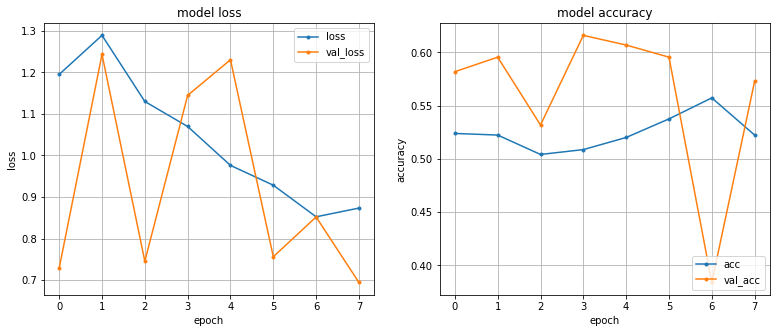

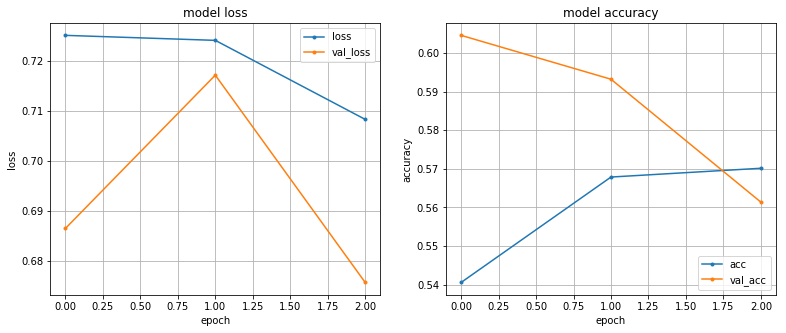

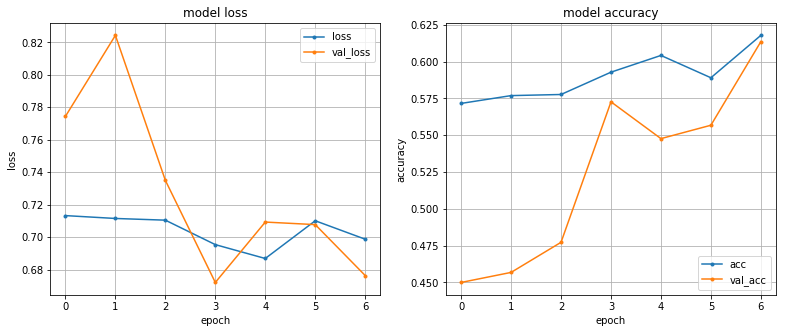

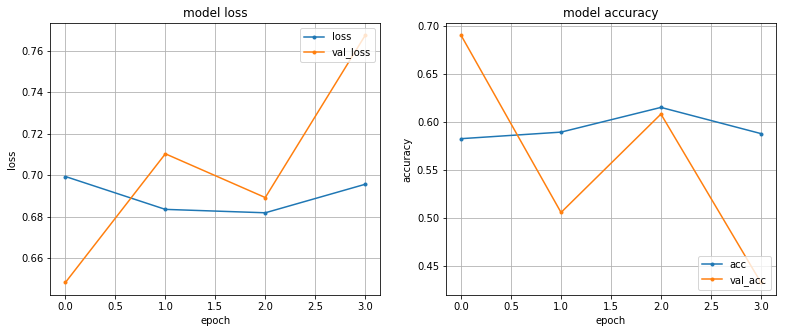

In [23]:
X = data1_N
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [25]:
loss,acc=model.evaluate(X_H,Y_H);print(loss,acc)

198/198 [==============================] - 1s 3ms/step
0.661425052267 0.590909090909


## KFOLD FOR KAGGLE AND NSCLC  WITHOUT NORMALIZATION

Train on 1632 samples, validate on 545 samples
Epoch 1/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.9682 - acc: 0.6134 - val_loss: 4.7397 - val_acc: 0.3872
Epoch 2/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.8902 - acc: 0.6366 - val_loss: 2.3805 - val_acc: 0.3963
Epoch 3/15
1632/1632 [==============================] - 12s 8ms/step - loss: 0.8825 - acc: 0.6397 - val_loss: 2.9048 - val_acc: 0.4165
Epoch 4/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.6993 - acc: 0.6373 - val_loss: 3.7723 - val_acc: 0.3872
Epoch 5/15
1632/1632 [==============================] - 12s 8ms/step - loss: 0.6573 - acc: 0.6593 - val_loss: 1.4843 - val_acc: 0.4606
Epoch 6/15
1632/1632 [==============================] - 13s 8ms/step - loss: 0.6665 - acc: 0.6440 - val_loss: 3.0879 - val_acc: 0.3890
Epoch 7/15
1632/1632 [==============================] - 12s 7ms/step - loss: 0.6078 - acc: 0.6544 - val_loss: 2.5363 - val_acc: 0.4349
Epoch 8/

1633/1633 [==============================] - 12s 7ms/step - loss: 0.6983 - acc: 0.5787 - val_loss: 5.9129 - val_acc: 0.1213
Validation Loss:  [0.81329940942996137, 0.68826141427544985, 0.65024865024230061, 3.7932112707811245]  Validation accuracy:  [0.52844036697247709, 0.57904411764705888, 0.64889705882352944, 0.66911764705882348]
Average Validation Loss:  1.48625518618
Average Validation Accuracy:  0.606374797625


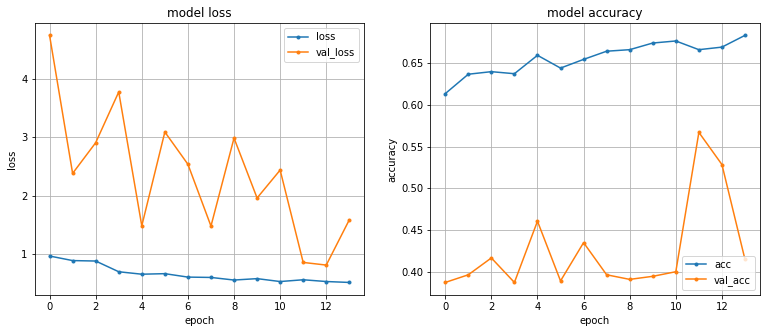

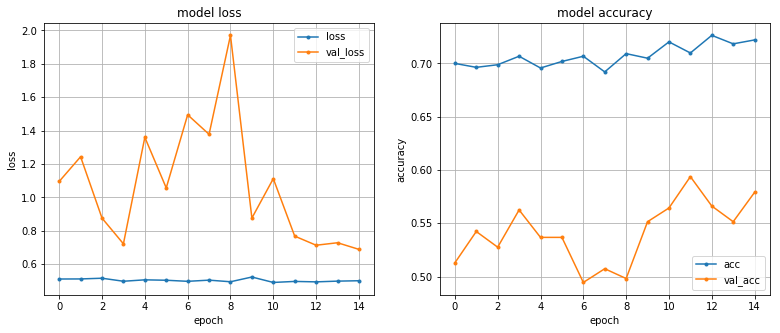

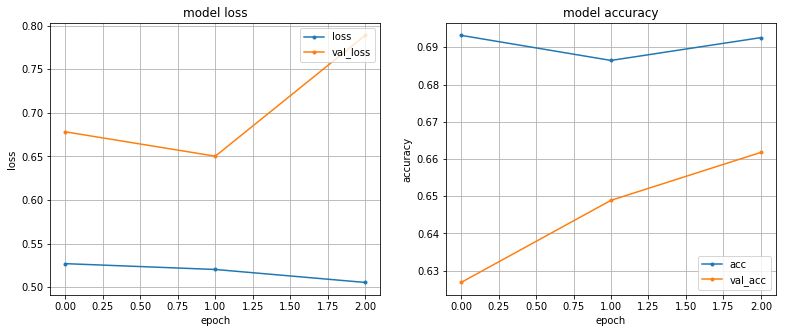

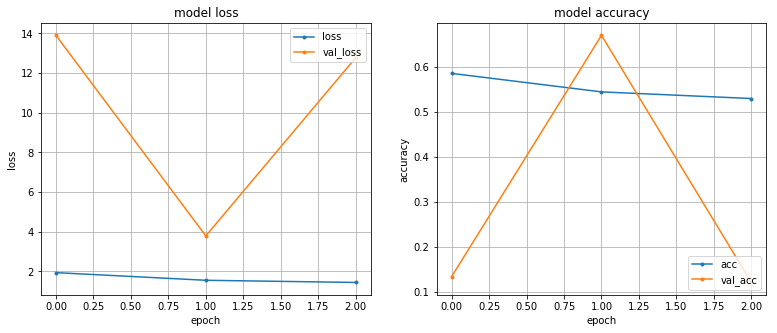

In [13]:
X = data2_N
Y = newlabel2
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [14]:
loss,acc=model.evaluate(X_H,Y_H);print(loss,acc)

198/198 [==============================] - 1s 3ms/step
0.674538113252 0.595959595358


## KAGGLE DIRECT

Train on 1047 samples, validate on 350 samples
Epoch 1/15
1047/1047 [==============================] - 6s 5ms/step - loss: 1.0353 - acc: 0.6504 - val_loss: 1.0663 - val_acc: 0.7400
Epoch 2/15
1047/1047 [==============================] - 5s 4ms/step - loss: 1.0867 - acc: 0.6180 - val_loss: 2.2411 - val_acc: 0.7400
Epoch 3/15
1047/1047 [==============================] - 5s 4ms/step - loss: 1.0025 - acc: 0.6447 - val_loss: 1.2554 - val_acc: 0.7400
Epoch 4/15
1047/1047 [==============================] - 5s 5ms/step - loss: 0.8679 - acc: 0.6466 - val_loss: 0.6589 - val_acc: 0.7400
Epoch 5/15
1047/1047 [==============================] - 5s 5ms/step - loss: 0.7825 - acc: 0.6724 - val_loss: 0.6341 - val_acc: 0.6971
Epoch 6/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.7414 - acc: 0.6800 - val_loss: 0.8844 - val_acc: 0.5771
Epoch 7/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.7397 - acc: 0.6953 - val_loss: 0.6963 - val_acc: 0.7314
Epoch 8/15
1047

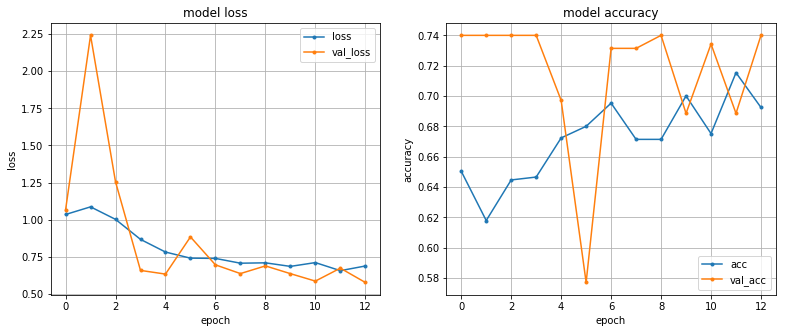

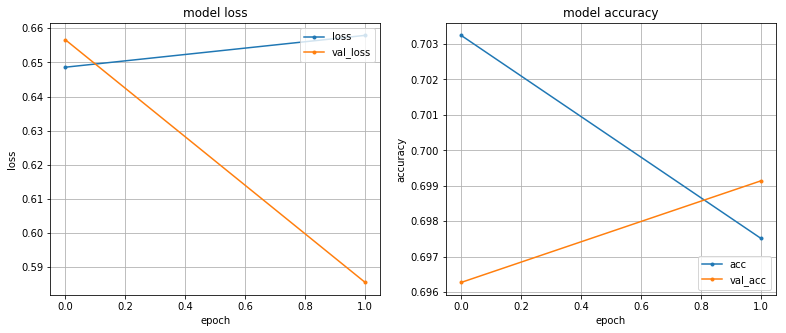

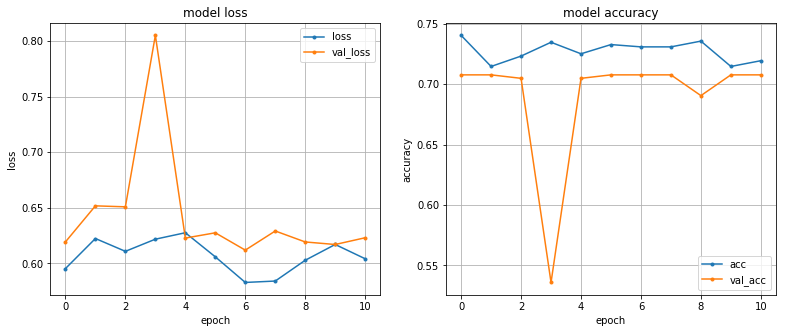

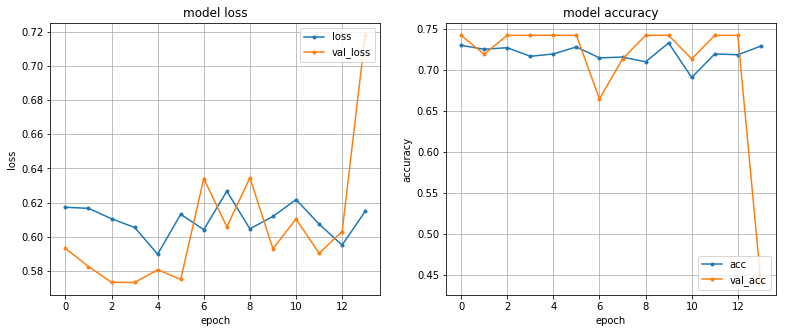

In [15]:
X = data1_N
Y = newlabel1
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))